### Imports und GPU Fixes

In [1]:
# Imports
import os
import warnings

# === WARNUNGEN STUMMSCHALTEN ===

# 1. Python-Warnungen
warnings.filterwarnings('ignore')

# 2. TensorFlow C++ Log-Level (z.B. "AVX2", "TF-TRT")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_LAYOUT_OPTIMIZER'] = '0'

# === GPU-FIXES ===

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, RandAugment, CutMix
from tensorflow.keras.optimizers import Adam
import time
import tensorflow.keras.backend as K
import numpy as np
import random
from tensorflow.keras import mixed_precision
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import keras

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# === GPU-KONFIGURATION ===

# TF32-Fix für GTX 1080 Ti
tf.config.experimental.enable_tensor_float_32_execution(False) 

# Memory Growth
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

except RuntimeError as e:
    print(e)

def set_experiment_seed(seed_value):
    """Setzt den globalen Seed für einen reproduzierbaren Experiment-Lauf."""
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    tf.random.set_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)

2026-01-09 12:47:01.158627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-09 12:47:01.303948: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-09 12:47:01.304976: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Konstanten

In [5]:
# ÄNDERN BEI JEDEM UNTERSCHIEDLICHEN EXPERIMENTLAUF
EXPERIMENT_SEED = 44      # Mögliche Werte: 42, 43, 44

#Konstanten NIE ÄNDERN
IMG_SIZE = (224, 224)
INPUT_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 16

PLANTDOC_DIR = '/mnt/c/Users/sandr/Desktop/Studium/thesis/praxis/data/plantdoc_cropped_xml_test'

# Baseline (Modell A) als Startpunkt
SOURCE_MODEL_FILE = f"models/model_A_seed_{EXPERIMENT_SEED}.keras"
    
# Dynamsicher Modellname
MODEL_NAME = f"model_D_seed_{EXPERIMENT_SEED}.keras"

# Setze den Seed für diesen neuen Lauf
set_experiment_seed(EXPERIMENT_SEED)

print(f"Start-Modell: {SOURCE_MODEL_FILE}")
print(f"Ziel-Modellname: {MODEL_NAME}")

Start-Modell: models/model_A_seed_44.keras
Ziel-Modellname: model_D_seed_44.keras


### Laden der Trainings- und Validierungsdaten
* Hier wird der gesamte PlantDoc Datensatz (bis auf 20% Testset) zum Training genutzt, um das obere Limit zu erforschen
* Vom Train-Dataset werden 10% als Validierungsdaten genutzt
* WICHTIG! Da PlantDoc sehr unbalanciert ist, benötigen wir für den Validation Split einen Stratefied Split und zum Training Class Weights
* WICHTIG! Um DataLeakage zu vermeiden muss der Split (20% Testset) unbedingt als GroupSplit erfolgen

In [6]:
import pathlib
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.utils import class_weight

print("Starte Daten-Vorbereitung für Modell D (Full Data) mit GROUP-AWARE SPLIT...")

# Augmentierung
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

try:
    data_dir = pathlib.Path(PLANTDOC_DIR)

    # 1. Alle Pfade laden
    image_paths = sorted(list(data_dir.glob('*/*')))
    image_paths = [str(path) for path in image_paths if not pathlib.Path(path).name.startswith('.')]

    # 2. Labels und Group-IDs extrahieren
    class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
    class_to_index = {name: i for i, name in enumerate(class_names)}
    NUM_CLASSES = len(class_names)
    
    all_labels = []
    all_groups = [] 

    for path in image_paths:
        label = class_to_index[pathlib.Path(path).parent.name]
        all_labels.append(label)
        
        # Group ID extrahieren (Originalbild-Name)
        filename = os.path.basename(path)
        if "_crop_" in filename:
            group_id = filename.rsplit("_crop_", 1)[0]
        else:
            group_id = filename
        all_groups.append(group_id)

    print(f"Gesamt: {len(image_paths)} Bilder in {NUM_CLASSES} Klassen.")

    # Test-Set abspalten (20%)

    cv_test = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=EXPERIMENT_SEED)
    
    # Der erste Fold wird unser Test-Set
    pool_idx, test_idx = next(cv_test.split(image_paths, all_labels, all_groups))

    # Daten aufteilen
    pool_paths = [image_paths[i] for i in pool_idx]
    pool_labels = [all_labels[i] for i in pool_idx]
    pool_groups = [all_groups[i] for i in pool_idx] # Gruppen-IDs für den nächsten Split behalten!
    
    test_paths = [image_paths[i] for i in test_idx]
    test_labels = [all_labels[i] for i in test_idx]
    
    print(f"Split 1 (Test) -> Pool: {len(pool_paths)}, Test: {len(test_paths)}")

    # Verbleibenden Pool in Train (90%) und Val (10%) splitten

    # n_splits=10 bedeutet: 1 Teil (10%) Validierung, 9 Teile (90%) Training
    cv_val = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=EXPERIMENT_SEED)
    
    train_idx, val_idx = next(cv_val.split(pool_paths, pool_labels, pool_groups))
    
    final_train_paths = [pool_paths[i] for i in train_idx]
    final_train_labels = [pool_labels[i] for i in train_idx]
    
    final_val_paths = [pool_paths[i] for i in val_idx]
    final_val_labels = [pool_labels[i] for i in val_idx]

    print(f"Split 2 (Val)  -> Train: {len(final_train_paths)}, Val: {len(final_val_paths)}")
    print("Keine Crops desselben Bildes befinden sich in unterschiedlichen Sets!")

    # Class Weights berechnen (Wichtig für Modell D, da Full Data unbalanciert ist)
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(final_train_labels),
        y=final_train_labels
    )
    class_weights_dict = dict(enumerate(class_weights))
    print("Klassengewichte berechnet.")

    # Datasets erstellen
    def load_and_preprocess_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        return img, tf.one_hot(label, NUM_CLASSES)
    
    def create_dataset(paths, labels, is_training=False):
        ds = tf.data.Dataset.from_tensor_slices((paths, labels))
        if is_training:
            ds = ds.shuffle(buffer_size=len(paths))
            ds = ds.repeat()
        ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        
        if is_training:
            ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                        num_parallel_calls=tf.data.AUTOTUNE)
        
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
        return ds

    ft_train_set = create_dataset(final_train_paths, final_train_labels, is_training=True)
    ft_val_set   = create_dataset(final_val_paths, final_val_labels, is_training=False)

    # Steps berechnen
    TRAIN_STEPS = len(final_train_paths) // BATCH_SIZE
    VAL_STEPS = len(final_val_paths) // BATCH_SIZE
    
    if len(final_train_paths) % BATCH_SIZE != 0: TRAIN_STEPS += 1
    if len(final_val_paths) % BATCH_SIZE != 0: VAL_STEPS += 1

    print(f"Train Steps: {TRAIN_STEPS}, Val Steps: {VAL_STEPS}")

except Exception as e:
    print(f"Fehler: {e}")
    import traceback
    traceback.print_exc()

Starte Daten-Vorbereitung für Modell D (Full Data) mit GROUP-AWARE SPLIT...
Gesamt: 8866 Bilder in 27 Klassen.
Split 1 (Test) -> Pool: 7126, Test: 1740
Split 2 (Val)  -> Train: 6327, Val: 799
Keine Crops desselben Bildes befinden sich in unterschiedlichen Sets!
Klassengewichte berechnet.
Train Steps: 396, Val Steps: 50



--- Erstelle Grafik für PlantDoc Verteilung ---
Grafik gespeichert: PlantDoc_Distribution_Weights.png


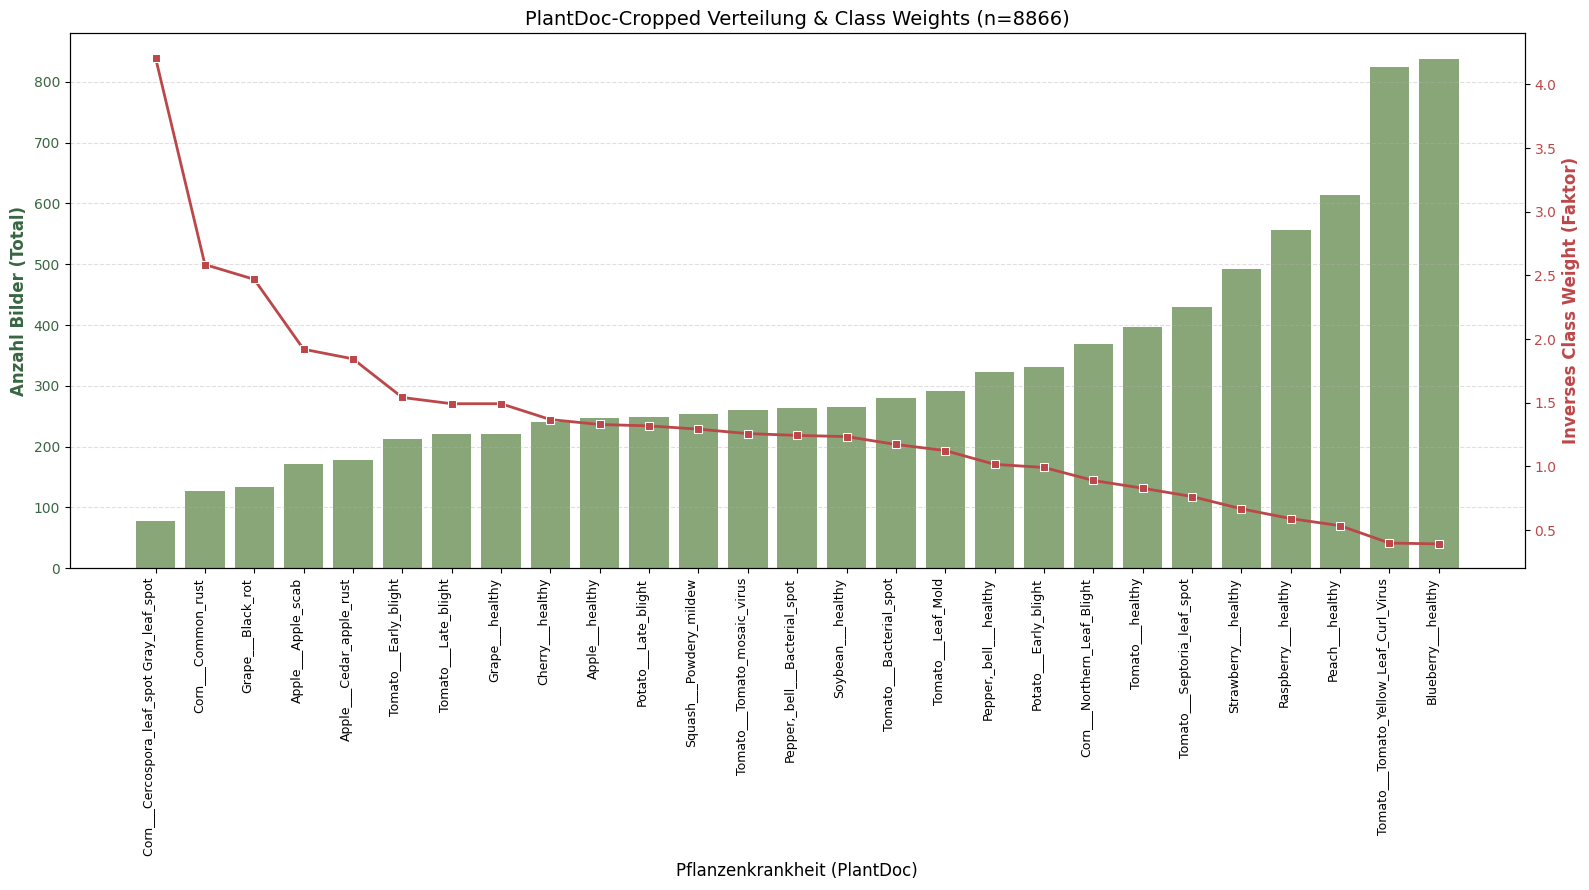

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- GRAFIK: Klassenverteilung und Gewichte für PlantDoc ---
print("\n--- Erstelle Grafik für PlantDoc Verteilung ---")

# 1. Daten aggregieren (Wir nehmen ALLE Labels, um den Datensatz zu zeigen)
# Da 'all_labels' eine Liste ist, wandeln wir sie kurz in ein numpy array um
all_labels_np = np.array(all_labels)
unique_indices_doc, counts_doc = np.unique(all_labels_np, return_counts=True)

# Gewichte für den Plot berechnen (auf Basis aller Daten)
weights_doc_plot = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_indices_doc,
    y=all_labels_np
)

# DataFrame bauen
data_doc = []
for idx in unique_indices_doc:
    name = class_names[idx]
    count = counts_doc[idx]
    weight = weights_doc_plot[idx]
    
    data_doc.append({
        'Klasse': name,
        'Anzahl Bilder': count,
        'Gewichtung': weight
    })

df_doc = pd.DataFrame(data_doc)

# Sortieren (Aufsteigend)
df_doc = df_doc.sort_values(by='Anzahl Bilder', ascending=True)

# 2. Plotten
fig, ax1 = plt.subplots(figsize=(16, 9)) # Etwas breiter, da Labels lang sind

# Balken (Anzahl) - in Grün für "Feld/Natur" Look
sns.barplot(data=df_doc, x='Klasse', y='Anzahl Bilder', color='#6a994e', alpha=0.8, ax=ax1)
ax1.set_xlabel('Pflanzenkrankheit (PlantDoc)', fontsize=12)
ax1.set_ylabel('Anzahl Bilder (Total)', color='#386641', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#386641')

# Labels rotieren
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right', fontsize=9)

# Linie (Gewichte) - Rot
ax2 = ax1.twinx()
sns.lineplot(data=df_doc, x='Klasse', y='Gewichtung', color='#bc4749', marker='s', linewidth=2, ax=ax2, sort=False)
ax2.set_ylabel('Inverses Class Weight (Faktor)', color='#bc4749', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#bc4749')

# Gitter und Titel
ax1.grid(True, axis='y', linestyle='--', alpha=0.4)
total_imgs_doc = len(all_labels)
plt.title(f'PlantDoc-Cropped Verteilung & Class Weights (n={total_imgs_doc})', fontsize=14)

plt.tight_layout()

# Speichern
save_path_doc = 'PlantDoc_Distribution_Weights.png'
plt.savefig(save_path_doc, dpi=300)
print(f"Grafik gespeichert: {save_path_doc}")
plt.show()

### FINETUNING: Mit NIEDRIGER LERNRATE auf PlantDoc finetunen

In [4]:
print(f" Starte Fine-Tuning für Modell D...")

# Lade das trainierte MODELL A
print(f"Lade Basis-Modell: {SOURCE_MODEL_FILE}")
model_to_finetune = keras.models.load_model(SOURCE_MODEL_FILE)

# Mit 5e-5 Lernrate neu kompilieren
model_to_finetune.compile(
    optimizer=Adam(learning_rate=5e-5), 
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    jit_compile=False
)

# Callbacks für dieses Experiment definieren
finetune_model_path = f"models/{MODEL_NAME}"

checkpoint_cb_ft = ModelCheckpoint(
    finetune_model_path,
    save_best_only=True,
    monitor="val_loss", 
    mode="min",
    verbose=1
)

early_stopping_cb_ft = EarlyStopping(
    monitor="val_loss", 
    patience=10,
    restore_best_weights=True
)

# Einfrieren überprüfen
def check_params(model):
    trainable = np.sum([K.count_params(w) for w in model.trainable_weights])
    frozen = np.sum([K.count_params(w) for w in model.non_trainable_weights])
    
    print(f"✅ Trainable (aktiv): {int(trainable):,}")
    print(f"❄️ Frozen (inaktiv):  {int(frozen):,}")
    print(f"∑  Total:             {int(trainable + frozen):,}")

# Aufruf
check_params(model_to_finetune)

# Training starten
EPOCHS = 50 
start_zeit = time.time()

history_finetune = model_to_finetune.fit(
    ft_train_set,                 
    validation_data=ft_val_set,  
    epochs=EPOCHS,
    steps_per_epoch=TRAIN_STEPS, 
    validation_steps=VAL_STEPS,  
    callbacks=[checkpoint_cb_ft, early_stopping_cb_ft],
    class_weight=class_weights_dict 
)

end_zeit = time.time()

print(f"\nFine-Tuning abgeschlossen. Dauer: {(end_zeit - start_zeit) / 60:.2f} Minuten")

 Starte Fine-Tuning für Modell D...
Lade Basis-Modell: models/model_A_seed_44.keras
✅ Trainable (aktiv): 4,344,983
❄️ Frozen (inaktiv):  44,583
∑  Total:             4,389,566
Epoch 1/50


2026-01-04 19:17:05.816331: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.3547 - loss: 2.4908
Epoch 1: val_loss improved from None to 1.89065, saving model to models/model_D_seed_44.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 225s 492ms/step - accuracy: 0.4329 - loss: 2.1772 - val_accuracy: 0.4984 - val_loss: 1.8907
Epoch 2/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.5478 - loss: 1.7282
Epoch 2: val_loss improved from 1.89065 to 1.78281, saving model to models/model_D_seed_44.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 189s 485ms/step - accuracy: 0.5596 - loss: 1.7203 - val_accuracy: 0.5645 - val_loss: 1.7828
Epoch 3/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.6087 - loss: 1.5652
Epoch 3: val_loss improved from 1.78281 to 1.72569, saving model to models/model_D_seed_44.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 186s 478ms/step - accuracy: 0.6173 - loss: 1.5597 - val_accuracy: 0.5790 - val_loss: 1.7257
Epoch 4/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.6428 - loss: 1.4608
Epoch 4:

### Trainingsverlauf

In [8]:
import matplotlib.pyplot as plt

# Daten aus dem 'history'-Objekt
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']

# Epochen, die tatsächlich gelaufen sind.
epochs_range = range(len(acc)) 

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # Plot 1: Genauigkeit
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) # Plot 2: Verlust
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(f"model_D_seed_{EXPERIMENT_SEED}_training.png")
plt.show()

NameError: name 'history_finetune' is not defined